In [1]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.cm as cm
import scipy.misc
import scipy.stats as sta
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')
import plotly.graph_objects as go
import plotly
from astropy.cosmology import WMAP9 as cosmo
from pandas.core.frame import DataFrame
from scipy.optimize import curve_fit
from scipy import integrate
#1pixel=0.25arcsec

In [2]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm
#绘制天区图像用

In [3]:
def calculate_flux_per_frequency(mag):
    flux_density=10**((48.6+mag)/(-2.5))
    return flux_density

def calculate_flux_per_wavelength(mag,corresponding_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    return intensity

def calculate_flux(mag,corresponding_lambda,delta_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    return flux

def calculate_distance(redshift):
    distance=redshift*3e5/70
    distance=distance*9.4607e17
    distance=distance*3.2616e6
    return(distance)

def calculate_continuum_flux_density(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    return continuum_flux_density

def calculate_continuum_subtracted_line_flux(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    continuum_subtracted_line_flux=flux_nb-continuum_flux_density*delta_lambda_nb
    return continuum_subtracted_line_flux

def calculate_SB(mag,corresponding_lambda,delta_lambda,area):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    surface_brightness=flux/(area*0.25*0.25)
    return surface_brightness
    
# unit： erg per second per quare centimeter per suqare arcsec

In [4]:
def choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return False
    return True

def wrong_choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return True
    return False

In [5]:
def show_nebula(img1,img2,img3,x,y,size):
    norm1 = Scaleimgconverter(img1)
    norm2 = Scaleimgconverter(img2)
    norm3 = Scaleimgconverter(img3)
    center=[np.array([x],float),np.array([y],float)]
    cutout1=Cutout2D(data, center,30, wcs = WCS(header))
    cutout2=Cutout2D(data2, center,30, wcs = WCS(header))
    cutout3=Cutout2D(datacut, center,30, wcs = WCS(header))
  
    x = x.astype(int)
    y = y.astype(int)
    x1=x-size
    x2=x+size
    y1=y-size
    y2=y+size
    fig = plt.figure()
    ax = plt.subplot(131,projection=cutout1.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img1[y1:y2,x1:x2],norm=norm1,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')
    
    fig = plt.figure()
    ax = plt.subplot(132,projection=cutout2.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img2[y1:y2,x1:x2],norm=norm2,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

    fig = plt.figure()
    ax = plt.subplot(133,projection=cutout3.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img3[y1:y2,x1:x2],norm=norm3,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

In [6]:
with open("BOSS1441_NB.csv",'w+',newline='') as csvfile:#创建一个新的csv文件
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('1441nb_d1.0x.cat','r',encoding = 'utf-8') as f:#打开那个.cat文件
        linelist = f.readlines()[13:]#从第十三行写起
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()#split（）函数，按括号中的内容分割，strip函数，移除头尾指定的字符
            spamwriter.writerow(line_list)

In [7]:
with open("BOSS1441_Bw.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('1441bw_d1.0x.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [8]:
SDSS6=pd.read_csv("SDSS6.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
BOSS1441_Bw=pd.read_csv("BOSS1441_Bw.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])
#index_col=False
BOSS1441_NB=pd.read_csv("BOSS1441_NB.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])#读取哪几列

In [9]:
SDSS6=pd.concat([SDSS6,(SDSS6['umag']-0.8116*(SDSS6['umag'] - SDSS6['gmag']) + 0.1313)],axis=1)#计算bmag
#axis： 需要合并链接的轴，0是行，1是列 

SDSS6.columns=['_RAJ2000', '_DEJ2000',  'RA_ICRS',  'DE_ICRS',     'mode',   'q_mode',\
          'class',   'SDSS12', 'm_SDSS!2',  'ObsDate',        'Q',     'umag',\
         'e_umag',     'gmag',   'e_gmag',     'rmag',   'e_rmag',     'imag',\
         'e_imag',     'zmag',   'e_zmag',      'zsp',      'zph',    'e_zph',\
          '<zph>',          'bmag']
#bmag是到这儿才加上来的

In [10]:
coord_sdss=SkyCoord(ra=SDSS6['_RAJ2000']*u.degree, dec=SDSS6['_DEJ2000']*u.degree)
#不乘u.degree会报错，但为什么也不是很清楚
coord_bw=SkyCoord(ra=BOSS1441_Bw['ALPHA_J2000']*u.degree, dec=BOSS1441_Bw['DELTA_J2000']*u.degree)
coord_nb=SkyCoord(ra=BOSS1441_NB['ALPHA_J2000']*u.degree, dec=BOSS1441_NB['DELTA_J2000']*u.degree)

In [11]:
idx, d2d, d3d = coord_sdss.match_to_catalog_sky(coord_bw)


In [12]:
index = np.where((d2d < Angle('0d00m0.5s'))&(SDSS6['bmag'] < 20)&(SDSS6['bmag'] > 16.5))#把其中符合条件的摘出来，即用index来标出距离足够小的object

In [13]:
idx=idx[index]#可以认为是同一个object的点的indices

In [14]:
SDSS6_RAJ2000=SDSS6._RAJ2000.data.obj#SDSS的RA
SDSS6_DEJ2000=SDSS6._DEJ2000.data.obj#SDSS的DEC
SDSS6_bmag=SDSS6.bmag.data.obj#SDSS的bmag
BOSS1441_Bw_list=BOSS1441_Bw.MAG_APER.data.obj#BOSS的Bw Mag

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [15]:
BOSS1441_Bw_list_standard=BOSS1441_Bw.MAG_APER.data.obj[idx]#BOSS中可被认为是相同object的部分
SDSS6_bmag_standard=SDSS6_bmag[index]#SDSS中可被认为是相同object的部分

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [16]:
zeropoint_bw=SDSS6_bmag_standard-BOSS1441_Bw_list_standard
zeropoint_bw=sigma_clip(zeropoint_bw, sigma=3, iters=10)

In [17]:
zp_bw=np.mean(zeropoint_bw)#Bw的zeropoint
zp_std_bw=np.std(zeropoint_bw)#Bw的standard deviation

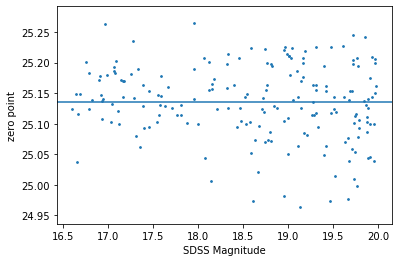

Bw的zeropoint为 25.13518084
Bw的standard deviation为 0.06008385005900087


In [18]:
plt.axhline(zp_bw)
plt.xlabel('SDSS Magnitude')
plt.ylabel('zero point')
plt.scatter(x=SDSS6_bmag_standard,y=zeropoint_bw,s=3)
#plt.axis([16.5, 20.5, 24, 26])
plt.show()

print('Bw的zeropoint为',zp_bw)
print('Bw的standard deviation为',zp_std_bw)

In [19]:
BOSS1441_Bw=pd.concat([BOSS1441_Bw,BOSS1441_Bw.MAG_APER+zp_bw],axis=1)
BOSS1441_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']
#重写Bw的dataframe，把加了zp的真实mag扔进去，新的一列就叫standard_mag

In [20]:
idx_nb, d2d_nb, d3d_nb = coord_nb.match_to_catalog_sky(coord_bw)
index_nb = np.where(d2d_nb < Angle('0d0m02s'))
idx_nb=idx_nb[index_nb]

In [21]:
BOSS1441_NB_match = BOSS1441_NB.MAG_APER.data.obj[index_nb]
#这是全部的可以与NB中对应成功的NB中的源的现在的nb_magnitude,包括galaxy和star
index_zp = np.where((BOSS1441_NB_match < 5) &(BOSS1441_NB_match > 0))
#这是全部可以用来计算zeropoint的NB的点

mid=BOSS1441_Bw.standard_mag.data.obj[idx_nb]
mag_bw_standard_select=mid[index_zp]#这里面写出来的则是与下面那个对应的bw中的标准的magnitude
mag_nb_standard_select=BOSS1441_NB_match[index_zp]#这里面写出来是标准的nb的magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [22]:
zeropoint_nb=mag_bw_standard_select-mag_nb_standard_select
zeropoint_nb=sigma_clip(zeropoint_nb, sigma=3, iters=10)

In [23]:
zp_nb=np.mean(zeropoint_nb)
zp_std_nb=np.std(zeropoint_nb)

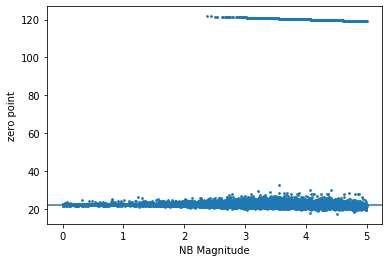

NB的zeropoint为 22.26922889641555
NB的standard deviation为 0.5259199586772351


In [24]:
plt.axhline(zp_nb)
plt.xlabel('NB Magnitude')
plt.ylabel('zero point')
plt.scatter(x=mag_nb_standard_select,y=mag_bw_standard_select-mag_nb_standard_select,s=3)
#plt.axis([0,5.5,18,30])
plt.show()

print('NB的zeropoint为',zp_nb)
print('NB的standard deviation为',zp_std_nb)

In [25]:
BOSS1441_NB=pd.concat([BOSS1441_NB,BOSS1441_NB.MAG_APER+zp_nb],axis=1)
BOSS1441_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

In [26]:
flux_bw=[]
flux_nb=[]

for i in range(len(BOSS1441_Bw.standard_mag.data.obj)):#对里面所有的点，求bw flux
    flux_bw.append(calculate_flux(BOSS1441_Bw.standard_mag.data.obj[i],4135,1278))
    
for i in range(len(BOSS1441_NB.standard_mag.data.obj)):#对里面所有的点,求nb flux
    flux_nb.append(calculate_flux(BOSS1441_NB.standard_mag.data.obj[i],4030,45))

flux_bw=DataFrame(flux_bw)#转换格式
flux_nb=DataFrame(flux_nb)#转换格式

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [27]:
BOSS1441_Bw=pd.concat([BOSS1441_Bw,flux_bw],axis=1)
BOSS1441_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw']

BOSS1441_NB=pd.concat([BOSS1441_NB,flux_nb],axis=1)
BOSS1441_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb']

In [28]:
Bw_1=pd.DataFrame()

Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.X_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.Y_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.ALPHA_J2000.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.DELTA_J2000.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.FLUX_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.FLUXERR_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.MAG_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.MAGERR_APER.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.FLAGS.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.NITER_MODEL.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.ISOAREA_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.ISOAREAF_IMAGE.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.standard_mag.data.obj[idx_nb])],axis=1)
Bw_1=pd.concat([Bw_1,DataFrame(BOSS1441_Bw.flux_bw.data.obj[idx_nb])],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will 

In [29]:
NB_1=pd.DataFrame()


NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.X_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.Y_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.ALPHA_J2000.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.DELTA_J2000.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.FLUX_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.FLUXERR_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.MAG_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.MAGERR_APER.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.FLAGS.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.NITER_MODEL.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.ISOAREA_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.ISOAREAF_IMAGE.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.standard_mag.data.obj[index_nb])],axis=1)
NB_1=pd.concat([NB_1,DataFrame(BOSS1441_NB.flux_nb.data.obj[index_nb])],axis=1)
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb']


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will 

In [30]:
print(len(Bw_1))
print(len(NB_1))

47359
47359


In [31]:
F_bw=Bw_1.flux_bw.data.obj
F_nb=NB_1.flux_nb.data.obj

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [32]:
cont_flux_per_wavelength=[]
for i in range(len(F_bw)):
    #cont_flux_per_wavelength.append((F_bw[i]-F_nb[i])/(1278-45))
    cont_flux_per_wavelength.append(calculate_continuum_flux_density(F_bw[i],F_nb[i],1278,45))
    
#得到了continuum flux density,下面要反求magnitude

In [33]:
Bw_1=pd.concat([Bw_1,DataFrame(cont_flux_per_wavelength)],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_wavelength']

NB_1=pd.concat([NB_1,DataFrame(cont_flux_per_wavelength)],axis=1)
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_wavelength']

In [34]:
minus_number=[]
for i in range(len(cont_flux_per_wavelength)):
    if (cont_flux_per_wavelength[i]<0):
        #print(cont_flux_per_wavelength[i])
        minus_number.append(i)
print(len(minus_number))

819


In [35]:
Bw_1.drop(minus_number,inplace=True)
NB_1.drop(minus_number,inplace=True)
Bw_1.reset_index(drop=True, inplace=True)
NB_1.reset_index(drop=True, inplace=True)

In [36]:
Bw_1=pd.concat([Bw_1,Bw_1.cont_flux_per_wavelength*(4135**2)/(3e8*1e10)],axis=1)
NB_1=pd.concat([NB_1,NB_1.cont_flux_per_wavelength*(4135**2)/(3e8*1e10)],axis=1)

Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_wavelength','cont_flux_per_frequency']
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_wavelength','cont_flux_per_frequency']

In [37]:
cont_bw=[]
for i in range(len(Bw_1)):
    cont_bw.append((-2.5*math.log(Bw_1.cont_flux_per_frequency.data.obj[i],10)-48.6))
print(len(cont_bw))

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



46540


In [38]:
Bw_1=pd.concat([Bw_1,DataFrame(cont_bw)],axis=1)
NB_1=pd.concat([NB_1,DataFrame(cont_bw)],axis=1)
Bw_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']
NB_1.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']

In [39]:
print(len(Bw_1.cont_bw.data.obj))

46540


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [40]:
bw_sub_nb=[]
for i in range(len(NB_1)):
    bw_sub_nb.append(Bw_1.standard_mag.data.obj[i]-NB_1.standard_mag.data.obj[i])

#continuum_Bw-NB magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



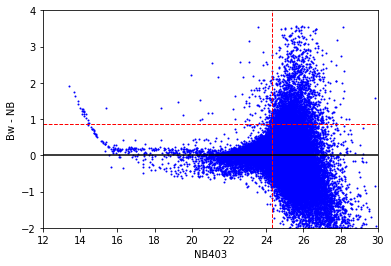

In [41]:
plt.scatter(NB_1.standard_mag.data, bw_sub_nb, color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.87, color='r', linestyle='--', linewidth = 1)
plt.axvline(24.3, color='r', linestyle='--', linewidth = 1)
plt.axis([12,30,-2,4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [42]:
w = WCS('bwcut.fits')
data,header=fits.getdata('bwcut.fits',header=True)
data2,header2=fits.getdata('nbcut.fits',header=True)

datacut=10**((zp_bw - zp_nb)/2.5) * data2-data
#datacut=10**((zp_bw - zp_nb)/2.5) * data2-data2
dataadd=10**((zp_bw - zp_nb)/2.5) * data2+data

norm = Scaleimgconverter(datacut)

lenx=len(data[0])
leny=len(data)
#最后两行暂时不知道有啥用

In [43]:
index_candidate=[]
for i in range(len(Bw_1)):
    if (Bw_1.standard_mag.data.obj[i]-NB_1.standard_mag.data.obj[i] > 0.87) \
        & (NB_1.standard_mag.data.obj[i]< 24.3):
        if choose(datacut,NB_1.X_IMAGE.data.obj[i],NB_1.Y_IMAGE.data.obj[i],-10,40):
            index_candidate.append(i)

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [44]:
Bw_2=pd.DataFrame()

Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.X_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.Y_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ALPHA_J2000.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.DELTA_J2000.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLUX_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLUXERR_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.MAG_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.MAGERR_APER.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.FLAGS.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.NITER_MODEL.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ISOAREA_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.ISOAREAF_IMAGE.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.standard_mag.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.flux_bw.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_flux_per_frequency.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_flux_per_wavelength.data.obj[index_candidate])],axis=1)
Bw_2=pd.concat([Bw_2,DataFrame(Bw_1.cont_bw.data.obj[index_candidate])],axis=1)
Bw_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will 

In [45]:
NB_2=pd.DataFrame()

NB_2=pd.concat([NB_2,DataFrame(NB_1.X_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.Y_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ALPHA_J2000.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.DELTA_J2000.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLUX_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLUXERR_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.MAG_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.MAGERR_APER.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.FLAGS.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.NITER_MODEL.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ISOAREA_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.ISOAREAF_IMAGE.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.standard_mag.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.flux_nb.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_flux_per_frequency.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_flux_per_wavelength.data.obj[index_candidate])],axis=1)
NB_2=pd.concat([NB_2,DataFrame(NB_1.cont_bw.data.obj[index_candidate])],axis=1)
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will 

In [46]:
NB_2=pd.concat([NB_2,NB_2.flux_nb-(NB_2.cont_flux_per_wavelength*45)],axis=1)
Bw_2=pd.concat([Bw_2,NB_2.flux_nb-(NB_2.cont_flux_per_wavelength*45)],axis=1)

Bw_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux']
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux']

#计算 line flux 没啥问题好吧

In [58]:
distance=cosmo.comoving_distance((4030-1215.7)/1215.7).value*3.2615637771418798291*9.46*1e23*(4030-1215.7)/1215.7
#distance=calculate_distance(2.3)
Bw_2=pd.concat([Bw_2,DataFrame(4*math.pi*distance**2*Bw_2.line_flux.data.obj)],axis=1)
NB_2=pd.concat([NB_2,DataFrame(4*math.pi*distance**2*NB_2.line_flux.data.obj)],axis=1)
#emitter_1=pd.concat([emitter_1,DataFrame(4*math.pi*distance**2*emitter_1.flux_bw.data.obj)],axis=1)

Bw_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_bw','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux','luminosity']
NB_2.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux','luminosity']

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version



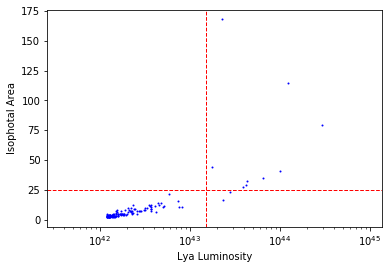

In [60]:
plt.semilogx()
plt.scatter(NB_2.luminosity,NB_2.ISOAREAF_IMAGE*(0.0625), color = 'b', s=1)
plt.axhline(25, color='r', linestyle='--', linewidth = 1)
plt.axvline(1.5e43, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

In [62]:
lya=pd.DataFrame()
for i in range(len(emitter_1)):
    if (NB_2.luminosity.data.obj[i]> 1.5e43) and ((NB_2.ISOAREAF_IMAGE.data.obj[i]*(0.0625))> 25):
        lya=pd.concat([lya,NB_2.loc[i:i]],ignore_index = True)


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [66]:
lya=pd.concat([lya,DataFrame(calculate_SB(lya.cont_bw.data.obj,4135,1278,lya.ISOAREAF_IMAGE.data.obj*0.0625))],axis=1)

lya.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag','flux_nb','cont_flux_per_frequency','cont_flux_per_wavelength','cont_bw','line_flux','luminosity','surface_brightness']
#???关于用到的surface brightness的delta_lambda什么的？

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



ValueError: Length mismatch: Expected axis has 21 elements, new values have 20 elements

In [67]:
print(lya)

     X_IMAGE    Y_IMAGE  ALPHA_J2000  DELTA_J2000  FLUX_APER  FLUXERR_APER  \
0  5020.2817   907.1506   220.173712    39.788475   2.230225      2.251447   
1  3442.1912  1359.4780   220.316275    39.820116   5.346549      3.485910   
2  4295.1074  1517.6509   220.239128    39.830997   4.952483      3.354991   
3  3950.3606  2520.9619   220.270137    39.900719   8.352592      4.357004   
4  4670.1973  2543.1631   220.204971    39.902151  15.805270      5.993446   
5  2618.7688  4361.5669   220.390594    40.028645  12.657100      5.363438   
6  3050.3345  4711.5024   220.351426    40.052925   2.902365      2.568386   
7  2686.3586  5533.7007   220.384406    40.110041   5.462415      3.523478   

   MAG_APER  MAGERR_APER  FLAGS  NITER_MODEL  ...  ISOAREAF_IMAGE  \
0   -0.8709       1.0963      3            7  ...             702   
1   -1.8202       0.7081      0           28  ...             459   
2   -1.7371       0.7357      0           12  ...             440   
3   -2.3046       0.5

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

Series.data is deprecated and will be removed in a future version



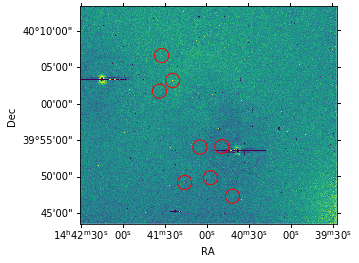

<Figure size 432x288 with 0 Axes>

In [68]:
ax = plt.subplot(projection=WCS(header))
fig = plt.figure()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(datacut, origin='lower',norm=norm,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')
ax.scatter(lya.X_IMAGE.data.obj, lya.Y_IMAGE.data.obj, color='', marker='o', edgecolors='r', s=200)

In [69]:
def Gaussian2D(r, sigma):
    return (1/(2*np.pi*sigma**2))*np.exp(-r**2/2/sigma**2)

def f_i(i, x, sigma):
    x1 = np.delete(x, i, axis=1)
    r = np.sqrt((x[0][i]-x1[0])**2 + (x[1][i]-x1[1])**2)
    Sum = np.sum(Gaussian2D(r, sigma))
    return Sum

def Likelyhood(x, sigma):
    list = [f_i(i, x, sigma) for i in range(len(x[0]))]
    Prod = np.prod(list)
    return Prod

In [70]:
hdu1 = fits.open('bwcut.fits')[0]
wcs1 = WCS(hdu1.header)#; hdu1.close()

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version



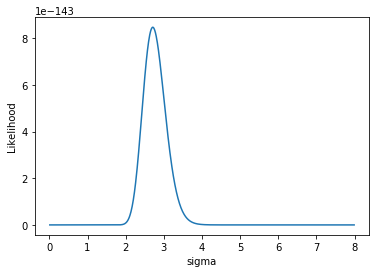

sigma is 2.8000000000000003 [arcmin]


In [71]:


ra, dec = wcs1.all_pix2world(NB_2.X_IMAGE.data.obj, NB_2.Y_IMAGE.data.obj,1)
emitter=np.vstack([60*ra, 60*dec])#把度转换成arcmin

step = 0.01
sigma = np.arange(step, 8, step)
Lh = [Likelyhood(emitter, s) for s in sigma]
plt.plot(sigma,Lh)
# plt.semilogy()
plt.xlabel('sigma')
plt.ylabel('Likelihood')
plt.show()

Sigma = Lh.index(max(Lh))*step+0.1
print('sigma is {}'.format(Sigma),'[arcmin]')
#求出做高斯分布的sigma

In [72]:
len_ra=wcs1.array_shape[0]*0.25/60
len_dec=wcs1.array_shape[1]*0.25/60

area=len_ra*len_dec
print(area,'arcmin**2')
#求整个field的面积，0.25是单个pixel对应的arcsec长度,再除60就是arcmin的长度了

1049.18578125 arcmin**2


In [73]:
ave_density=len(NB_2)/area
print('average density:',ave_density)

average density: 0.12676496610690224


In [74]:
binwidth = 100# sampling step
xx, yy = np.meshgrid(np.arange(0, wcs1.array_shape[0], binwidth), np.arange(0, wcs1.array_shape[1], binwidth))
#这一步就是分成100个区域-----一万个？貌似是一万个
ra_xx, dec_yy = wcs1.all_pix2world(xx+binwidth/2, yy+binwidth/2, 1)
#把这几个区域的中心做出来，一开始是用pixel的x和y值表示的，然后用wcs1.all_pix2world转化成用ra与dec表示
ra_xx, dec_yy = 60*ra_xx, 60*dec_yy
#再乘60，单位变成arcmin


In [75]:
f = [Gaussian2D(np.sqrt((ra_xx - emitter[0, i])**2 + (dec_yy - emitter[1, i])**2), Sigma) for i in range(len(emitter[0]))]
#这样做出来的f中的每一行，都是1个emitter对于1w个天区做高斯平滑后得到的单独个数分布


In [76]:
f = np.sum(f, axis=0)/abs(ra_xx[0, 1]-ra_xx[0, 0])/abs((dec_yy[1, 0]-dec_yy[0, 0]))#/ave_density

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:251: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning:

The following kwargs were not used by contour: 'lw'

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



[0, 7100, 0, 8400]

<Figure size 576x576 with 0 Axes>

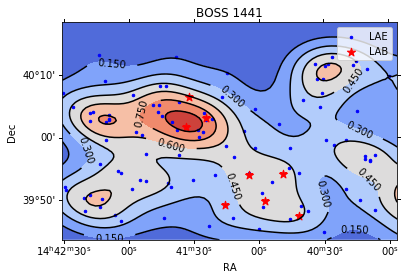

In [77]:
fig = plt.figure(figsize=(8, 8))
fig = plt.figure()
ax = fig.gca(projection=wcs1)

cfset = ax.contourf(xx, yy, f, cmap='coolwarm', lw=1)
cset = ax.contour(xx, yy, f, colors='k', lw=1)

ax.scatter(NB_2.X_IMAGE.data.obj, NB_2.Y_IMAGE.data.obj, marker='.', color='blue', s=25, label='LAE')
ax.scatter(lya.X_IMAGE.data.obj, lya.Y_IMAGE.data.obj, marker='*', color='r', s=75, label='LAB')
ax.legend()

ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

plt.title('BOSS 1441')

plt.axis([xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]])

In [117]:
redshift_z=((4030-1215.7)/1215.7)

In [118]:
radii_z=cosmo.comoving_distance(redshift_z)#半径

In [119]:
angle_ra=len_ra/60
angle_dec=len_dec/60

In [120]:
length_ra=(angle_ra/180)*np.pi*radii_z
length_dec=(angle_dec/180)*np.pi*radii_z
area_field=length_ra*length_dec

In [121]:
velB= (cosmo.comoving_distance(redshift_z+45/2/1215.7)-cosmo.comoving_distance(redshift_z-45/2/1215.7))

In [122]:
volume=velB*area_field

In [123]:
binwidth = 0.2#luminosity每隔10e0.2划分一个bin

In [124]:
mag = np.log10(emitter_1['luminosity'])

In [125]:
exponent=np.arange(binwidth*(min(mag)//binwidth-1), binwidth*(max(mag)//binwidth+1), binwidth)
print(exponent)
print(len(exponent))

[41.8 42.  42.2 42.4 42.6 42.8 43.  43.2 43.4 43.6 43.8 44.  44.2 44.4]
14


In [126]:
y_lumi_func=np.histogram(mag, bins=exponent)[0]/volume.value
#数密度,即y轴坐标

In [127]:
print(np.histogram(mag, bins=exponent)[0])
print(np.histogram(mag, bins=exponent)[1])

print(len(np.histogram(mag, bins=exponent)[0]))
print(len(np.histogram(mag, bins=exponent)[1]))
#没错，就是要少一个，因为是在区间里面！

[ 0 50 34 16  8  3  0  3  2  2  2  1  0]
[41.8 42.  42.2 42.4 42.6 42.8 43.  43.2 43.4 43.6 43.8 44.  44.2 44.4]
13
14


In [128]:
x_lumi_func = np.power(10,np.arange(binwidth*(min(mag)//binwidth-1)+0.1, binwidth*(max(mag)//binwidth+1)-0.1, binwidth))
#x轴坐标来了！这里要注意一下把它变成和y轴一样多的，就是取两个区间中间的值！


In [129]:
lumi_func = np.delete(np.vstack([x_lumi_func, y_lumi_func]), np.where(y_lumi_func==0) ,axis=1)

In [130]:
error = np.sqrt(lumi_func[1]*volume.value)/volume.value#误差
error = np.sqrt(lumi_func[1]*volume.value)/volume.value#误差

In [131]:

def LuminoFunc(L, phi_star, L_star, alpha):
    return (phi_star)*np.power((L/L_star),alpha)*np.exp(-L/L_star)
#luminosity function的定义

In [132]:
param_bounds =([10**-7., 10**40., -2], [1, 10**44., -1.0])

In [133]:
popt_1, pcov_1 = curve_fit(LuminoFunc, lumi_func[0], lumi_func[1], p0=[10**(-4), 10**42.4, -1.3], bounds=param_bounds, maxfev=50000)


In [134]:
phi_star = popt_1[0]; L_star = popt_1[1]; alpha = popt_1[2]
print('phi*=', phi_star)
print('L*=', L_star)
print('alpha=', alpha)

xvals = np.linspace(10**41.5, 10**43,200)
yvals = LuminoFunc(xvals, phi_star, L_star, alpha)

#phi_star0, L_star0, alpha0 = 0.0005, 10**42.33, -1.65 #constant at z=2.3
#phi_star0, L_star0, alpha0 = 10**(-2.86), 10**42.33, -1.65 #constant at z=2.3
phi_star0, L_star0, alpha0 = 10**(-2.86), 10**42.33, -1.65 #constant at z=2.3
#phi_star0, L_star0, alpha0 = 10**(-3.15), 10**42.82, -1.65 #constant at z=2.3
v, err = integrate.quad(LuminoFunc, 0.65, 1000, args=(phi_star0, L_star0, alpha0)) # N_field
# print('err=',err)
# v = v * 15**3; print('random field Lya number density:', v, '/Mpc3')

phi*= 0.0002693200857666714
L*= 2.511886431509572e+42
alpha= -1.3000000062268144


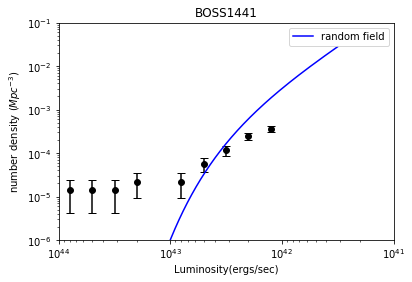

In [135]:
fig,ax = plt.subplots()
plt.semilogx()
plt.semilogy()

plt.scatter(lumi_func[0], lumi_func[1], color = 'black', edgecolors='black', marker='o', s=35)
plt.errorbar(lumi_func[0], lumi_func[1], fmt='None', yerr=error, ecolor='black', capsize=4)
plt.plot(xvals, LuminoFunc(xvals, phi_star0, L_star0, alpha0), color='b', label='random field')

ax.set_xlim(10e43,10e40)
ax.set_ylim(10e-7,10e-2)

ax.invert_xaxis()

plt.title('BOSS1441')
plt.xlabel('Luminosity(ergs/sec)')
plt.ylabel('number density ($Mpc^{-3}$)')
plt.legend()

In [ ]:
10**